In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

In [30]:
n_proteins = 300
n_samples_per_group = 25
total_samples = n_samples_per_group * 2

In [31]:
# Generate protein IDs
protein_ids = [f'Protein_{i+1}' for i in range(n_proteins)]

In [32]:
data = np.zeros((n_proteins, total_samples))

In [33]:
idx_pval_lt_0_01 = np.arange(0, 100)
idx_pval_0_01_to_0_1 = np.arange(100, 200)
idx_non_significant = np.arange(200, n_proteins)

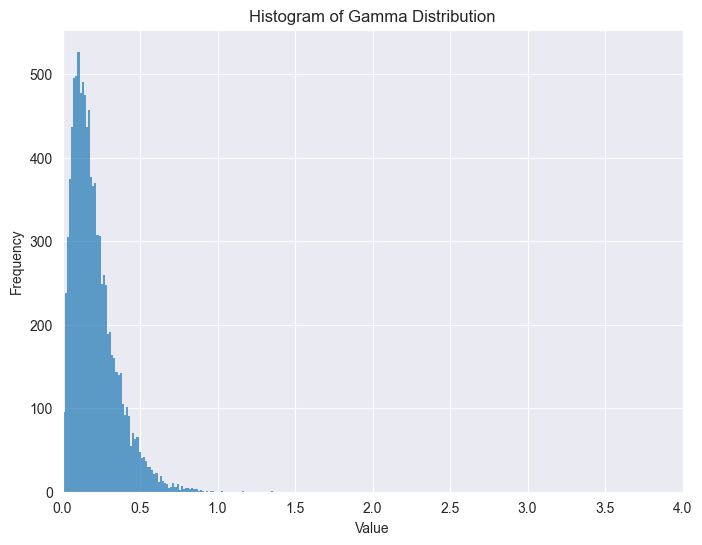

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data from a gamma distribution
shape_k = 2.0    # shape parameter > 1 to move peak away from 0
scale_theta = 0.1  # scale parameter (controls spread)

data = np.random.gamma(shape=shape_k, scale=scale_theta, size=10000)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, alpha=0.7, edgecolor='none')
plt.xlim(0, 4)
plt.title('Histogram of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

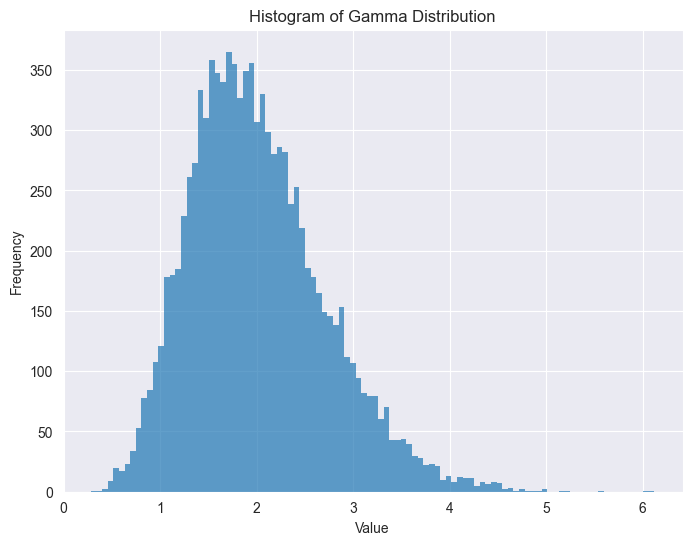

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data from a gamma distribution
shape_k = 8    # shape parameter > 1 to move peak away from 0
scale_theta = 0.25  # scale parameter (controls spread)

data = np.random.gamma(shape=shape_k, scale=scale_theta, size=10000)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, alpha=0.7, edgecolor='none')

plt.title('Histogram of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [36]:
pvals_lt_0_01_counts = 0
pvals_lt_0_01 = []

while pvals_lt_0_01_counts < 100:

    shape_k = 8    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.25
    fc = np.random.gamma(shape=shape_k, scale=scale_theta)
    fc = np.random.normal(2, 0.5)

    loc = np.random.randint(8, 20)

    shape_k = 2.0    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.1  # scale parameter (controls spread)
    scale = np.random.gamma(shape=shape_k, scale=scale_theta)

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if (
            #(0.0 < p_val <= 0.01) and
            p_val <= 0.05 and
            pvals_lt_0_01_counts < 100
    ):

        if -np.log10(p_val) < 40 and group2.mean() - group1.mean() > 0:

            pvals_lt_0_01.append(np.concatenate([group1, group2]))

            pvals_lt_0_01_counts += 1


In [37]:
# pvals_0_01_counts = 0
# pvals_0_01_to_0_1 = []
#
# while pvals_0_01_counts < 100:
#
#     fc = np.random.normal(0.0, 0.5)
#
#     loc = np.random.randint(8, 20)
#
#     shape_k = 2.0    # shape parameter > 1 to move peak away from 0
#     scale_theta = 0.1  # scale parameter (controls spread)
#     scale = np.random.gamma(shape=shape_k, scale=scale_theta)
#
#     group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
#     group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)
#
#     t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
#
#     if p_val > 0.01 and pvals_0_01_counts < 100:
#
#         pvals_0_01_to_0_1.append(np.concatenate([group1, group2]))
#         pvals_0_01_counts += 1


In [38]:
num_pval_gt_0_1 = 0

pvals_gt_0_1 = []

while num_pval_gt_0_1 < n_proteins - 100:

    fc = np.random.normal(0, 0.5)

    loc = np.random.randint(8, 20)

    shape_k = 2.0    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.1  # scale parameter (controls spread)
    scale = np.random.gamma(shape=shape_k, scale=scale_theta)

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if p_val > 0.01:

        pvals_gt_0_1.append(np.concatenate([group1, group2]))

        num_pval_gt_0_1 += 1



In [39]:
data = np.concatenate(
    [
        pvals_lt_0_01,
        #pvals_0_01_to_0_1,
        pvals_gt_0_1,
    ]
)

In [40]:
data

array([[19.03978224, 18.97563684, 18.59913523, ..., 19.4521772 ,
        19.57254988, 19.43267017],
       [10.20061529,  9.93222258, 10.10921629, ..., 11.27824986,
        11.74084095, 11.59031927],
       [11.24633098, 11.15488615, 10.64139724, ..., 12.3481989 ,
        12.79395083, 12.45557189],
       ...,
       [17.6357732 , 18.36111614, 18.33867467, ..., 17.31553498,
        17.69865034, 17.67036518],
       [18.02697854, 18.34708311, 18.04325028, ..., 18.35075966,
        18.10814035, 18.39605937],
       [18.56418193, 18.18266405, 18.26326894, ..., 17.82708932,
        16.63119238, 17.69429023]])

In [41]:
samples = [f'Sample_{i+1}' for i in range(total_samples)]
df = pd.DataFrame(data, index=protein_ids, columns=samples)
df = df.reset_index(names="Protein")

In [42]:
group_labels = ['Group1'] * n_samples_per_group + ['Group2'] * n_samples_per_group

In [43]:
design_matrix = pd.DataFrame(
    {
        "sample": samples,
        "group": group_labels,
    }
)

In [44]:
design_matrix.to_csv(
    "../tests/input_files/simulated_design_matrix.tsv",
    sep="\t",
    index=False,
)

In [45]:
df.to_csv(
    "../tests/input_files/simulated_proteins.tsv",
    sep="\t",
    index=False,
)

In [46]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=df,
    design_matrix_file=design_matrix,
)

In [47]:
quant_matrix = quant_matrix.compare(
    method="anova",
    comparisons=("Group2", "Group1"),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh",
)

In [48]:
da_df = quant_matrix.row_annotations

In [49]:
da_df[da_df['CorrectedPValueGroup2-Group1'] <= 0.01]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
0,Protein_1,0.356691,19.520082,18.991030,0.176330,0.174425,0.529053,5.880715e-14,25,25,1.109455e-13,12.954890
1,Protein_2,0.901199,11.602853,9.970697,0.190281,0.203174,1.632156,6.839904e-32,25,25,2.910936e-31,30.535967
2,Protein_3,0.781375,12.714662,10.914085,0.258220,0.396921,1.800578,1.308990e-23,25,25,3.373877e-23,22.471871
3,Protein_4,0.472997,13.016701,12.099621,0.254637,0.259321,0.917081,1.578994e-16,25,25,3.041642e-16,15.516892
4,Protein_5,1.157981,14.263268,12.000958,0.185515,0.192470,2.262310,3.030621e-39,25,25,5.546037e-38,37.256017
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Protein_96,1.134746,12.834561,10.100008,0.339999,0.304674,2.734553,2.593715e-32,25,25,1.249079e-31,30.903410
96,Protein_97,0.992742,16.488963,14.010834,0.319091,0.437830,2.478129,4.532682e-27,25,25,1.430139e-26,25.844622
97,Protein_98,0.830974,10.285035,8.040301,0.472748,0.557593,2.244734,8.542397e-20,25,25,1.736954e-19,18.760212
98,Protein_99,0.868213,19.178636,17.010256,0.414568,0.385286,2.168380,9.510993e-24,25,25,2.486445e-23,22.604421


In [50]:
da_df[da_df['Protein'] == "Protein_101"]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
100,Protein_101,0.053022,11.792567,11.949031,0.351,0.342039,-0.156464,0.124384,25,25,0.127878,0.893206


In [51]:
da_df.sort_values(by="CorrectedPValueGroup2-Group1", ascending=True)

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
88,Protein_89,1.414214,18.241920,15.008110,0.262386,0.193775,3.233810,1.810650e-42,25,25,3.313489e-40,39.479714
89,Protein_90,1.141004,11.947212,10.026888,0.156693,0.130855,1.920325,2.141034e-41,25,25,1.574181e-39,38.802945
58,Protein_59,1.173700,18.149302,16.013443,0.174998,0.147642,2.135858,3.166764e-41,25,25,1.574181e-39,38.802945
60,Protein_61,1.195068,16.302047,14.041798,0.184492,0.157724,2.260248,3.440833e-41,25,25,1.574181e-39,38.802945
26,Protein_27,1.124510,11.903229,9.982255,0.143418,0.156851,1.920974,1.394339e-40,25,25,4.584937e-39,38.338667
...,...,...,...,...,...,...,...,...,...,...,...,...
220,Protein_221,0.000789,8.053292,8.050958,0.224565,0.199535,0.002335,9.697872e-01,25,25,5.981364e-01,0.223200
218,Protein_219,0.001142,14.922327,14.918840,0.247853,0.292129,0.003487,9.646186e-01,25,25,5.981364e-01,0.223200
296,Protein_297,0.000386,12.009070,12.008078,0.122530,0.121643,0.000992,9.776687e-01,25,25,6.003804e-01,0.221573
192,Protein_193,0.000361,17.031444,17.032575,0.319312,0.392049,-0.001131,9.913018e-01,25,25,6.046941e-01,0.218464


In [52]:
da_df['ProteinNum'] = da_df['Protein'].str.split("_").str[-1].astype(int)

In [53]:
da_df['DAType'] = np.where(da_df['ProteinNum'] <= 100, 1, np.where(da_df['ProteinNum'] < 200, 2, 0))

<Axes: xlabel='Log2FoldChangeGroup2-Group1', ylabel='-Log10CorrectedPValueGroup2-Group1'>

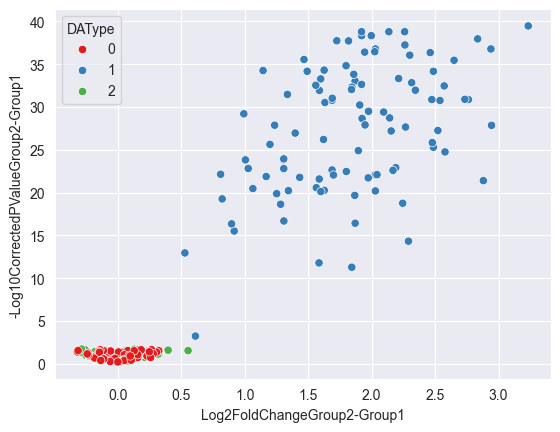

In [54]:
sns.scatterplot(
    data=da_df,
    x="Log2FoldChangeGroup2-Group1",
    y="-Log10CorrectedPValueGroup2-Group1",
    hue="DAType",
    palette="Set1",
)

In [27]:
da_df

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1,ProteinNum,DAType
0,Protein_1,0.611962,10.325277,10.005668,0.513933,0.537900,0.319609,6.384266e-21,500,500,4.757379e-19,18.322632,1,1
1,Protein_2,0.098939,17.063754,17.023624,0.180206,0.167111,0.040131,2.784064e-04,500,500,1.392032e-02,1.856351,2,1
2,Protein_3,0.996976,9.361219,9.041304,0.370667,0.379646,0.319915,4.097088e-38,500,500,1.544287e-35,34.811272,3,1
3,Protein_4,1.154303,10.576409,10.036481,0.613543,0.609071,0.539928,1.523415e-40,500,500,3.732366e-37,36.428016,4,1
4,Protein_5,0.483148,12.037911,12.000647,0.063359,0.062550,0.037264,5.610459e-20,500,500,3.984239e-18,17.399655,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Protein_4996,0.006940,19.007756,19.002782,0.182253,0.183738,0.004974,6.677570e-01,500,500,7.901496e-01,0.102291,4996,0
4996,Protein_4997,0.007280,9.007188,9.002031,0.181856,0.176919,0.005157,6.498759e-01,500,500,7.766810e-01,0.109757,4997,0
4997,Protein_4998,0.040362,12.077672,12.043749,0.429630,0.428220,0.033922,2.118773e-01,500,500,4.024026e-01,0.395339,4998,0
4998,Protein_4999,0.054933,15.962653,15.996203,0.231676,0.231787,-0.033550,2.241142e-02,500,500,1.646317e-01,0.783487,4999,0


In [28]:
quant_matrix.quantitative_data.X

array([[10.14258148,  9.91448125, 11.08235873, ...,  9.91630875,
         9.65543791, 10.55578213],
       [16.8514186 , 17.07972941, 17.00737852, ..., 17.31159483,
        16.93258008, 16.89292357],
       [ 8.74827668,  9.32851764,  9.14832183, ...,  9.06408633,
         8.77289403,  9.95907766],
       ...,
       [12.35418135, 11.68026659, 12.03466644, ..., 12.32600914,
        12.44196912, 11.51297096],
       [16.18859594, 15.94877871, 15.62885679, ..., 15.56679893,
        15.92952884, 16.30447773],
       [ 8.90036931,  9.04326378,  9.22281911, ...,  8.66543625,
         9.40623195,  8.95010901]])

<Axes: xlabel='Log2FoldChangeGroup2-Group1', ylabel='Count'>

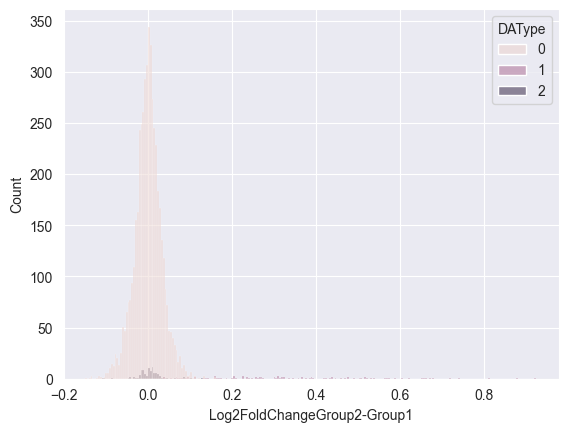

In [36]:
sns.histplot(
    data=da_df,
    x="Log2FoldChangeGroup2-Group1",
    hue="DAType",
)